### Introduction
In this notebook, we show the variables which went into the costs analysis section of the document:
"What makes Filecoin, Filecoin"

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import mechafil.data as mecha_data

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u

from cel_utils import disk_utils

In [3]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/filp_costs')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

current_date = date(2023,7,31) - timedelta(days=3)
start_date = date(current_date.year, current_date.month, 1)
forecast_length = 365*3
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-28 2026-07-27


In [5]:
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date)
day_vec = np.arange(0,len(hist_fpr))

In [6]:
scenarios = ['pessimistic', 'status-quo', 'optimistic']
scenario_scalers = [0.5, 1.0, 1.5]

sector_duration = 365
lock_target = 0.3
rbp_base = np.median(hist_rbp[-30:])
rr_base = np.median(hist_rr[-30:])
fpr_base = np.median(hist_fpr[-30:])

scenario2results = {}
for ii, scenario_scaler in enumerate(scenario_scalers):    
    scenario = scenarios[ii]
    
    rbp = jnp.ones(forecast_length) * rbp_base * scenario_scaler
    rr = jnp.ones(forecast_length) * rr_base * scenario_scaler
    fpr = jnp.ones(forecast_length) * fpr_base
    
    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    scenario2results[scenario] = simulation_results

<IPython.core.display.Javascript object>


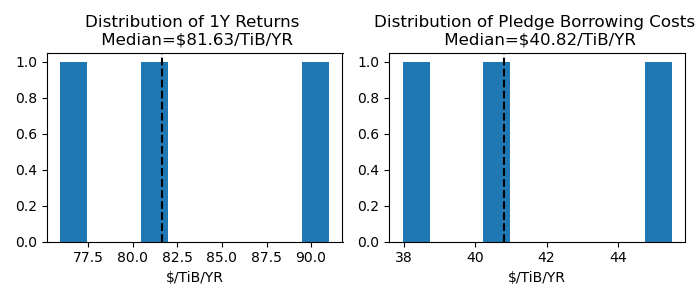

In [192]:
k = '1y_return_per_sector'
tib_per_sector = (1024**4)/C.SECTOR_SIZE
multiplier=10

# rewards_pct_vec = np.linspace(0.3, 0.7, 25)
rewards_pct_vec = [0.5]
# exchange_rate_vec = np.linspace(4,10,25)
exchange_rate_vec = [4]

block_rewards = []
pledge_borrowing_costs = []
for rewards_pct in rewards_pct_vec:
    for exchange_rate in exchange_rate_vec:
        for scenario in scenarios:
            x = float(scenario2results[scenario][k][0]*tib_per_sector*multiplier*exchange_rate)
            block_rewards.append(x)
            
            pledge_borrowing_cost = x*rewards_pct
            pledge_borrowing_costs.append(pledge_borrowing_cost)

block_rewards = np.asarray(block_rewards)
pledge_borrowing_costs = np.asarray(pledge_borrowing_costs)
            
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.hist(block_rewards)
plt.axvline(np.median(block_rewards), color='k', linestyle='--')
plt.title("Distribution of 1Y Returns \n Median=$%0.02f/TiB/YR" % (np.median(block_rewards),))
plt.xlabel('$/TiB/YR')


plt.subplot(1,2,2)
plt.hist(pledge_borrowing_costs)
plt.axvline(np.median(pledge_borrowing_costs), color='k', linestyle='--')
plt.title("Distribution of Pledge Borrowing Costs \n Median=$%0.02f/TiB/YR" % (np.median(pledge_borrowing_costs),))
plt.xlabel('$/TiB/YR')

plt.tight_layout()

In [193]:
sealing_costs_tib_per_yr = 1.3

gas_cost_tib_per_yr = (2250.+108.)/1024.
gas_cost_without_psd_tib_per_yr = 108./1024.
power_cost_tib_per_yr = 6000/1024.0
bandwidth_10gbps_tib_per_yr = 6600/1024.0
bandwidth_1gbps_tib_per_yr = 660/1024.0
bandwidth_100mbps_tib_per_yr = 66/1024.0
staff_cost_tib_per_yr = 42000/1024.0
# staff_cost_tib_per_yr = 21000/1024.0

data_prep_cost_tib_per_yr = 32
penalty_tib_per_yr = 1

bd_cost_tib_per_yr = 8

In [197]:
staff_cost_tib_per_yr

41.015625

In [194]:
# build a dataframe with costs so that we can plot things easily
sp_cost_list = []
filp_miner = {
    'SP Type': 'FIL+',
    'block_rewards': np.median(block_rewards),
    'deal_income': deal_income_tib_per_yr,
    'pledge_cost': np.median(pledge_borrowing_costs),
    'gas_cost': gas_cost_tib_per_yr,
    'power_cost': power_cost_tib_per_yr,
    'bandwidth_cost': bandwidth_10gbps_tib_per_yr,
    'staff_cost': staff_cost_tib_per_yr,
    'sealing_cost': sealing_costs_tib_per_yr,
    'data_prep_cost': data_prep_cost_tib_per_yr,
    'bd_cost': bd_cost_tib_per_yr
}
rd_miner = {
    'SP Type': 'Regular Deal',
    'block_rewards': np.median(block_rewards)/multiplier,
    'deal_income': deal_income_tib_per_yr,
    'pledge_cost': np.median(pledge_borrowing_costs)/multiplier,
    'gas_cost': gas_cost_without_psd_tib_per_yr,
    'power_cost': power_cost_tib_per_yr,
    'bandwidth_cost': bandwidth_10gbps_tib_per_yr,
    'staff_cost': staff_cost_tib_per_yr,
    'sealing_cost': sealing_costs_tib_per_yr,
    'data_prep_cost': data_prep_cost_tib_per_yr,
    'bd_cost': bd_cost_tib_per_yr
}
filp_cheat_miner = {
    'SP Type':'FIL+ Cheat',
    'block_rewards': np.median(block_rewards),
    'deal_income': deal_income_tib_per_yr,
    'pledge_cost': np.median(pledge_borrowing_costs),
    'gas_cost': gas_cost_tib_per_yr,
    'power_cost': power_cost_tib_per_yr,
    'bandwidth_cost': bandwidth_100mbps_tib_per_yr,
    'staff_cost': staff_cost_tib_per_yr,
    'sealing_cost': sealing_costs_tib_per_yr,
    'data_prep_cost': 0,
    'bd_cost': 0
}
cc_miner = {
    'SP Type':'CC',
    'block_rewards': np.median(block_rewards)/multiplier,
    'deal_income': 0,
    'pledge_cost': np.median(pledge_borrowing_costs)/multiplier,
    'gas_cost': gas_cost_without_psd_tib_per_yr,
    'power_cost': power_cost_tib_per_yr,
    'bandwidth_cost': bandwidth_100mbps_tib_per_yr,
    'staff_cost': staff_cost_tib_per_yr,
    'sealing_cost': sealing_costs_tib_per_yr,
    'data_prep_cost': 0,
    'bd_cost': 0
}
aws = {
    'SP Type':'AWS',
    'block_rewards': 0,
    'deal_income': 6.6,
    'pledge_cost': 0,
    'gas_cost': 0,
    'power_cost': 0,
    'bandwidth_cost': 0,
    'staff_cost': 0,
    'sealing_cost': 0,
    'data_prep_cost': 0,
    'bd_cost': 0
}
df = pd.DataFrame([filp_miner, rd_miner, filp_cheat_miner, cc_miner, aws])

In [195]:
df['profit'] = df['block_rewards'] + df['deal_income'] \
    - (df['pledge_cost'] + df['gas_cost'] + df['power_cost'] + df['bandwidth_cost'] + df['staff_cost'] + 
       df['sealing_cost'] + df['data_prep_cost'] + df['bd_cost'])
df

,SP Type,block_rewards,deal_income,pledge_cost,gas_cost,power_cost,bandwidth_cost,staff_cost,sealing_cost,data_prep_cost,bd_cost,profit
0,FIL+,81.633713,16.5,40.816856,2.302734,5.859375,6.445312,41.015625,1.3,32,8,-39.606190
1,Regular Deal,8.163371,16.5,4.081686,0.105469,5.859375,6.445312,41.015625,1.3,32,8,-74.144096
2,FIL+ Cheat,81.633713,16.5,40.816856,2.302734,5.859375,0.064453,41.015625,1.3,0,0,6.774669
3,CC,8.163371,0.0,4.081686,0.105469,5.859375,0.064453,41.015625,1.3,0,0,-44.263236
4,AWS,0.000000,6.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,6.600000


<IPython.core.display.Javascript object>


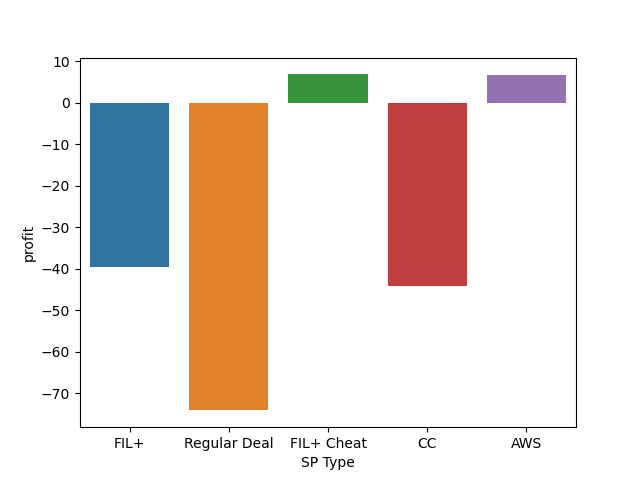

<Axes: xlabel='SP Type', ylabel='profit'>

In [196]:
plt.figure()
sns.barplot(df, x='SP Type', y='profit')

In [183]:
df_rel_cc = df[['SP Type', 'profit']]
df_rel_cc['profit'] -= df_rel_cc[df['SP Type']=='CC']['profit'].iloc[0]
cc_ix = df_rel_cc[df_rel_cc['SP Type']=='CC'].index
# print(cc_ix.index)
df_rel_cc = df_rel_cc.drop(cc_ix)
df_rel_cc

,SP Type,profit
0,FIL+,4.534426
1,Regular Deal,-29.880859
2,FIL+ Cheat,50.915286
4,AWS,50.876861


<IPython.core.display.Javascript object>


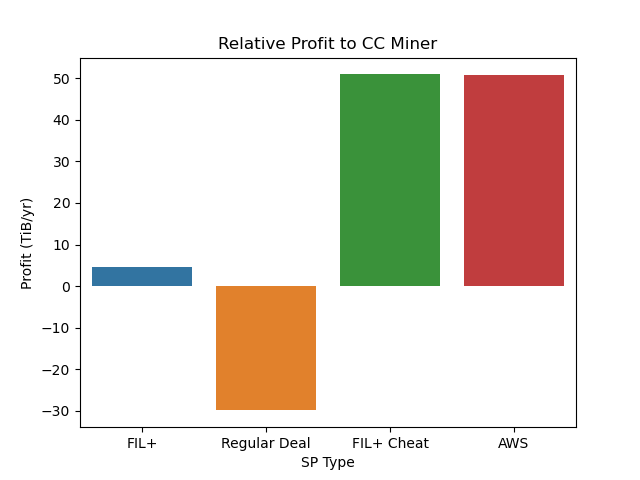

Text(0, 0.5, 'Profit (TiB/yr)')

In [184]:
plt.figure()
sns.barplot(df_rel_cc, x='SP Type', y='profit')
plt.title('Relative Profit to CC Miner')
plt.ylabel('Profit (TiB/yr)')

In [185]:
sealing_cost

array([-1.3, -1.3, -1.3, -1.3, -0. ])

<IPython.core.display.Javascript object>


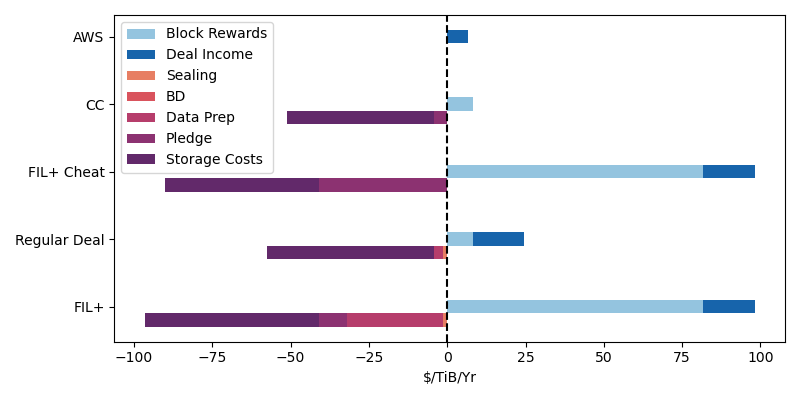

In [186]:
# angelo chart
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

br = np.median(br)

width = 0.2
x = np.arange(len(df))
labels = list(df['SP Type'])

# profits
br_vec = df['block_rewards'].values
deal_income_vec = df['deal_income'].values
ax.barh(labels, br_vec, width, label='Block Rewards', color=mpl.colormaps['Blues'](0.4))
ax.barh(x, deal_income_vec, width, left=br_vec, label='Deal Income', color=mpl.colormaps['Blues'](0.8))

cmap_access_vec = np.linspace(0.2, 0.9, 5)
cm=sns.color_palette("flare", as_cmap=True)
# costs
sealing_cost = -1*df['sealing_cost'].values
ax.barh(x-width, sealing_cost, width, label='Sealing', color=cm(cmap_access_vec[0]))
bd_cost = -1*df['bd_cost'].values
ax.barh(x-width, bd_cost, width, label='BD', color=cm(cmap_access_vec[1]), left=sealing_cost)
data_prep_cost = -1*df['data_prep_cost'].values
ax.barh(x-width, data_prep_cost, width, left=sealing_cost, label='Data Prep', color=cm(cmap_access_vec[2]))

pledge_cost = -1*df['pledge_cost'].values
ax.barh(x-width, pledge_cost, width, left=data_prep_cost, label='Pledge', color=cm(cmap_access_vec[3]))

storage_costs = -1*(df['gas_cost']+df['power_cost']+df['bandwidth_cost']+df['staff_cost'])
ax.barh(x-width, storage_costs, width, label='Storage Costs', left=pledge_cost, color=cm(cmap_access_vec[4]))

ax.axvline(0, color='k', linestyle='--')

plt.xlabel('$/TiB/Yr')
plt.legend()
plt.tight_layout()

In [202]:
import altair as alt
chart_data = pd.DataFrame(
    np.random.rand(9, 4),
    index=["air","coffee","orange","whitebread","potato","wine","beer","wheatbread","carrot"],
)
chart_data

,0,1,2,3
air,0.102047,0.389472,0.069660,0.467441
coffee,0.782517,0.799548,0.858556,0.809300
orange,0.354791,0.275414,0.538621,0.786081
whitebread,0.908815,0.555587,0.822319,0.368048
potato,0.103464,0.139964,0.550370,0.430525
wine,0.053788,0.685881,0.422621,0.401708
beer,0.252274,0.064231,0.120861,0.108053
wheatbread,0.312091,0.801249,0.447983,0.816086
carrot,0.296821,0.239487,0.476180,0.459205


In [200]:
data = pd.melt(chart_data.reset_index(), id_vars=["index"])

In [201]:
data

,index,variable,value
0,air,0,0.358619
1,coffee,0,0.987311
2,orange,0,0.588503
3,whitebread,0,0.474195
4,potato,0,0.995409
5,wine,0,0.936772
6,beer,0,0.505021
7,wheatbread,0,0.592608
8,carrot,0,0.345597
9,air,1,0.482504
